# Fish Weight Prediction and Variable Importance Visualization using Random Forests

## About Data
Copyright (c) 2020 Aung Pyae  
This program is free software; you can redistribute it and/or
modify it under the terms of the GNU General Public License
as published by the Free Software Foundation; either version 2
of the License, or any later version.  

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
GNU General Public License for more details.  

You should have received a copy of the GNU General Public License
along with this program. If not, see http://www.gnu.org/licenses/.  

[Fish market(kaggle)](https://www.kaggle.com/datasets/aungpyaeap/fish-market)

## About Code
This code aims to estimate the fish individuals' weight from their measurements using Random Forest.    
Also, In this code visualizes the importance of variables.

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.inspection import partial_dependence
import shap
import warnings

In [77]:
warnings.simplefilter('ignore')

In [2]:
%matplotlib inline
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.minor.visible'] = False
plt.rcParams['ytick.minor.visible'] = False

In [3]:
df = pd.read_csv('Data/Fish.csv')
df.insert(1, 'Species_Id', pd.factorize(df['Species'])[0])
df

,Species,Species_Id,Weight,Length1,Length2,Length3,Height,Width
0,Bream,0,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,0,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,0,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,0,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,0,430.0,26.5,29.0,34.0,12.4440,5.1340
...,...,...,...,...,...,...,...,...
154,Smelt,6,12.2,11.5,12.2,13.4,2.0904,1.3936
155,Smelt,6,13.4,11.7,12.4,13.5,2.4300,1.2690
156,Smelt,6,12.2,12.1,13.0,13.8,2.2770,1.2558
157,Smelt,6,19.7,13.2,14.3,15.2,2.8728,2.0672


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Species     159 non-null    object 
 1   Species_Id  159 non-null    int64  
 2   Weight      159 non-null    float64
 3   Length1     159 non-null    float64
 4   Length2     159 non-null    float64
 5   Length3     159 non-null    float64
 6   Height      159 non-null    float64
 7   Width       159 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 10.1+ KB


### Investigating Missing Values

In [5]:
print('Is there any NaN value in the dataset: ', df.isnull().values.any())

Is there any NaN value in the dataset:  False


### Different Species and Their Counts:

In [6]:
sp = df['Species'].value_counts()
df_sp = pd.DataFrame(sp)
df_sp.T

Species,Perch,Bream,Roach,Pike,Smelt,Parkki,Whitefish
count,56,35,20,17,14,11,6


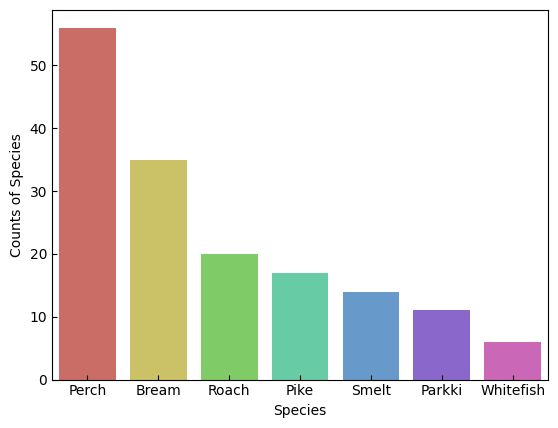

In [7]:
sns.barplot(x=df_sp.index, y=df_sp['count'], palette='hls')
plt.xlabel('Species')
plt.ylabel('Counts of Species')
plt.show()

### Correlation of the Variables without the variable of species

<Axes: >

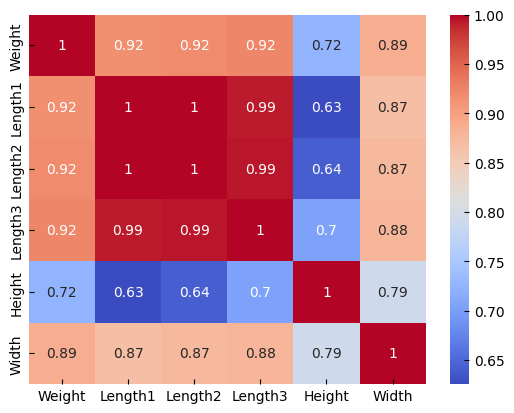

In [8]:
sns.heatmap(df.drop(['Species', 'Species_Id'],axis=1).corr(), annot=True, cmap='coolwarm')

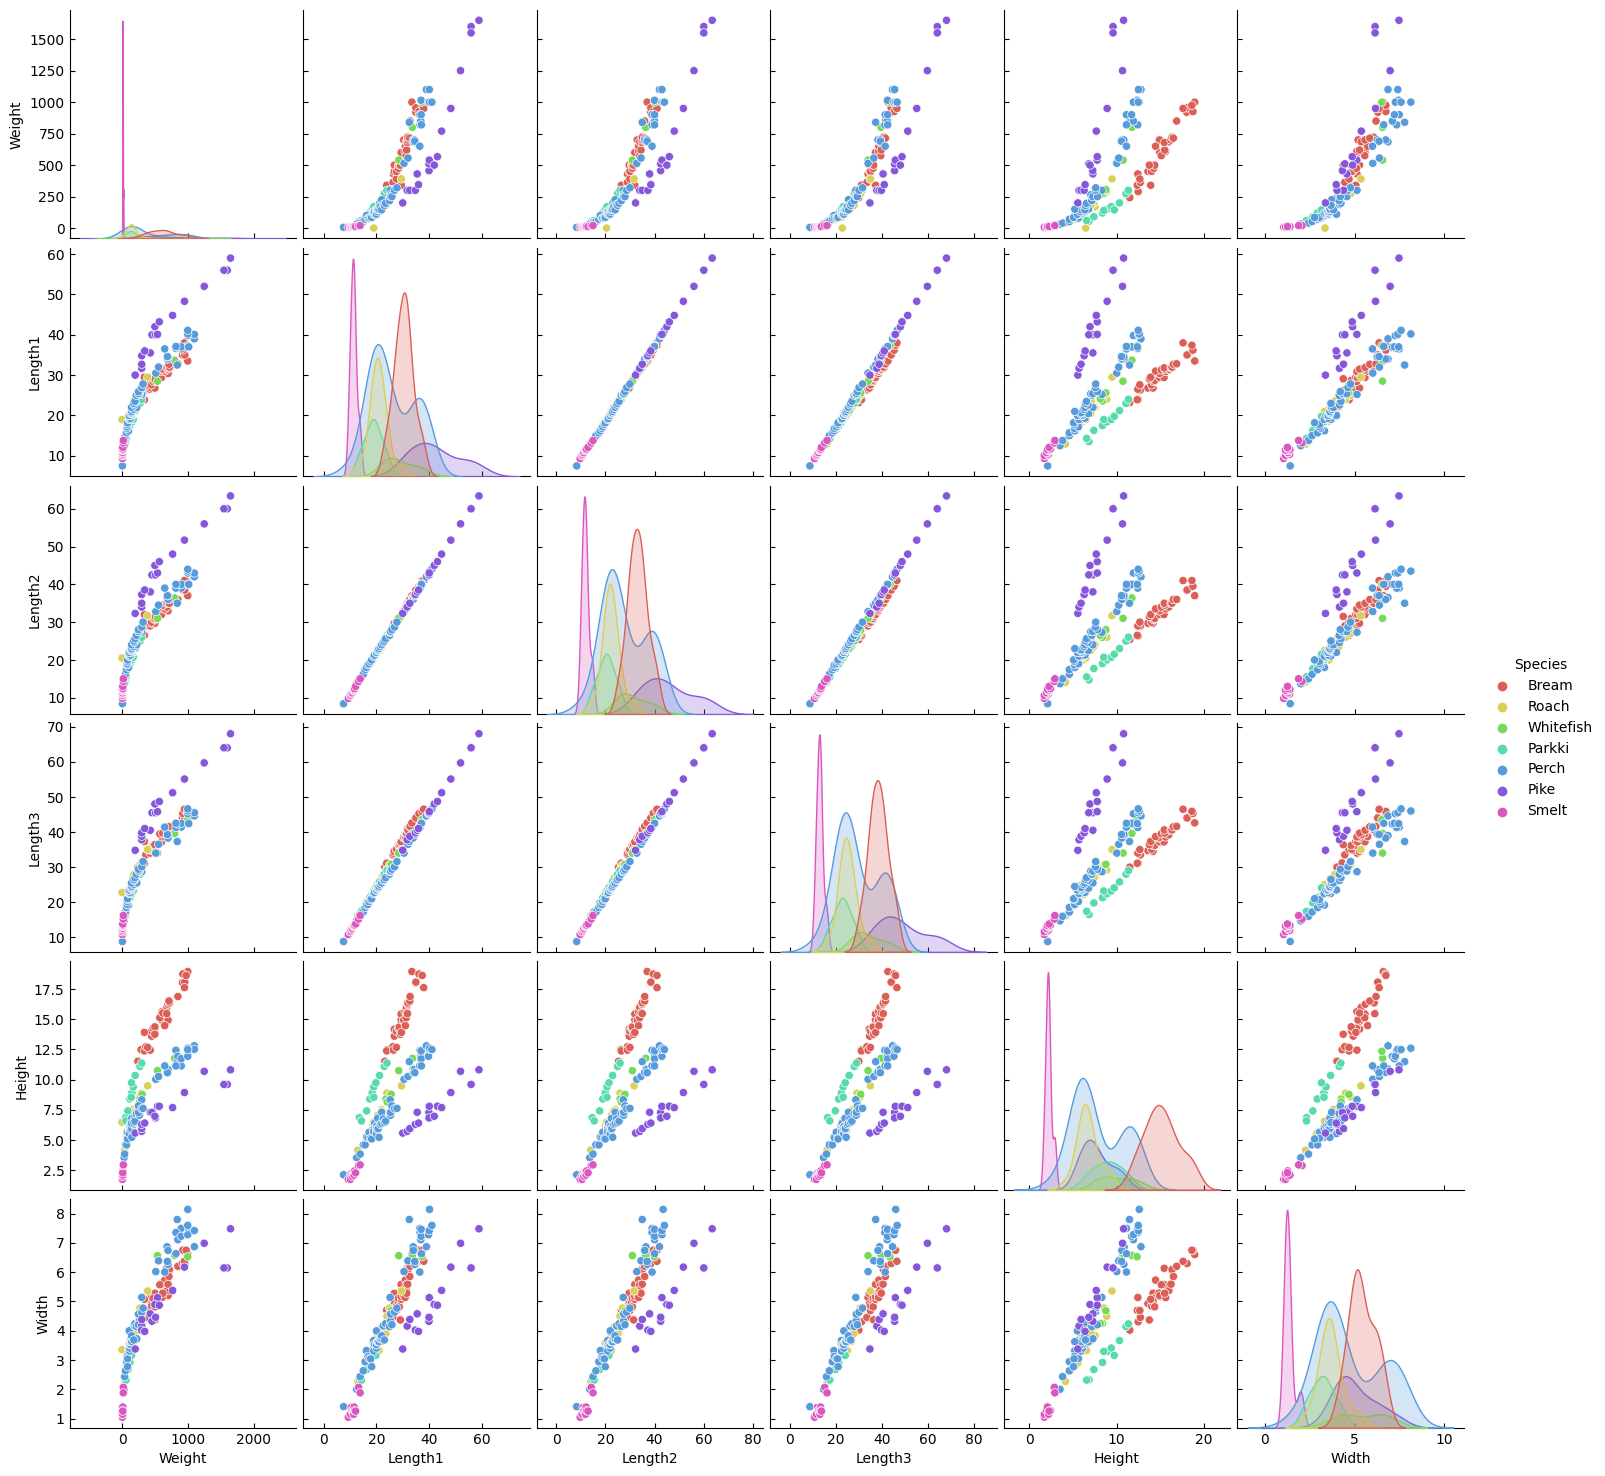

In [9]:
sns.pairplot(df.drop('Species_Id',axis=1), kind='scatter', hue='Species', palette='hls')

### Preparing the Random Forest modeling

In [10]:
X = df.drop(['Species','Weight'], axis=1)
y = df['Weight']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=314)

In [14]:
forest = RandomForestRegressor()

### Predictions

In [15]:
forest.fit(X_train, y_train)

RandomForestRegressor()

In [16]:
y_test_pred = forest.predict(X_test)

### Analysing the results of the Model from Train Dataset and Predictions

In [19]:
print('R2 : ', r2_score(y_test, y_test_pred))
print('MAE : ',mean_absolute_error(y_test, y_test_pred))
print('RMSE : ',np.sqrt(mean_squared_error(y_test, y_test_pred)))

R2 :  0.9685030605193581
MAE :  42.92772916666667
RMSE :  58.949743253552214


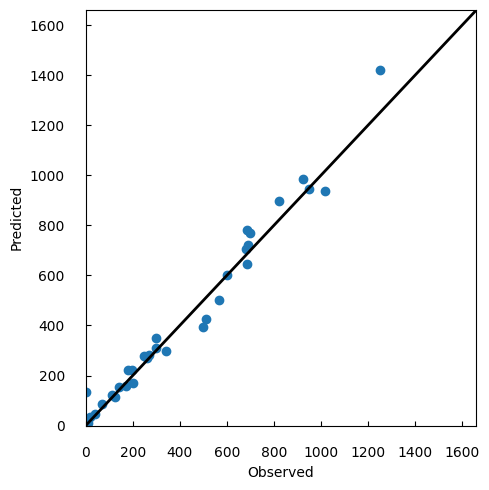

In [85]:
disp_min = 0
disp_max = y.max() + 10
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(y_test, y_test_pred)
ax.plot([disp_min, disp_max], [disp_min, disp_max], color='black', linewidth=2.0)
ax.set_xlim(disp_min, disp_max)
ax.set_ylim(disp_min, disp_max)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
ax.tick_params(pad=15)
fig.tight_layout()
fig.show()

### Variable Importance Visualization

#### Permutation Feature Importance

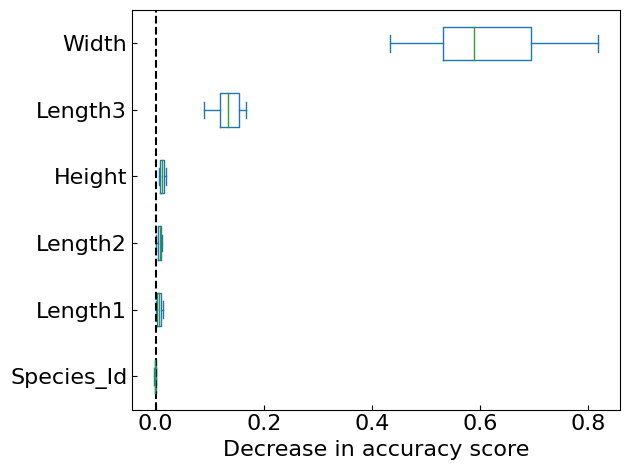

In [47]:
result = permutation_importance(forest, X_test, y_test, n_repeats=10, random_state=314)
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(result.importances[sorted_importances_idx].T,
                        columns=X_test.columns[sorted_importances_idx],)
ax = importances.plot.box(vert=False, whis=10,fontsize=16)
ax.axvline(x=0, color='k', linestyle='--')
ax.set_xlabel('Decrease in accuracy score',fontsize=16)
ax.figure.tight_layout()
plt.show()
plt.clf()
plt.close()

#### Partial Dependence (PD) and Individual Conditional Expectation (ICE)

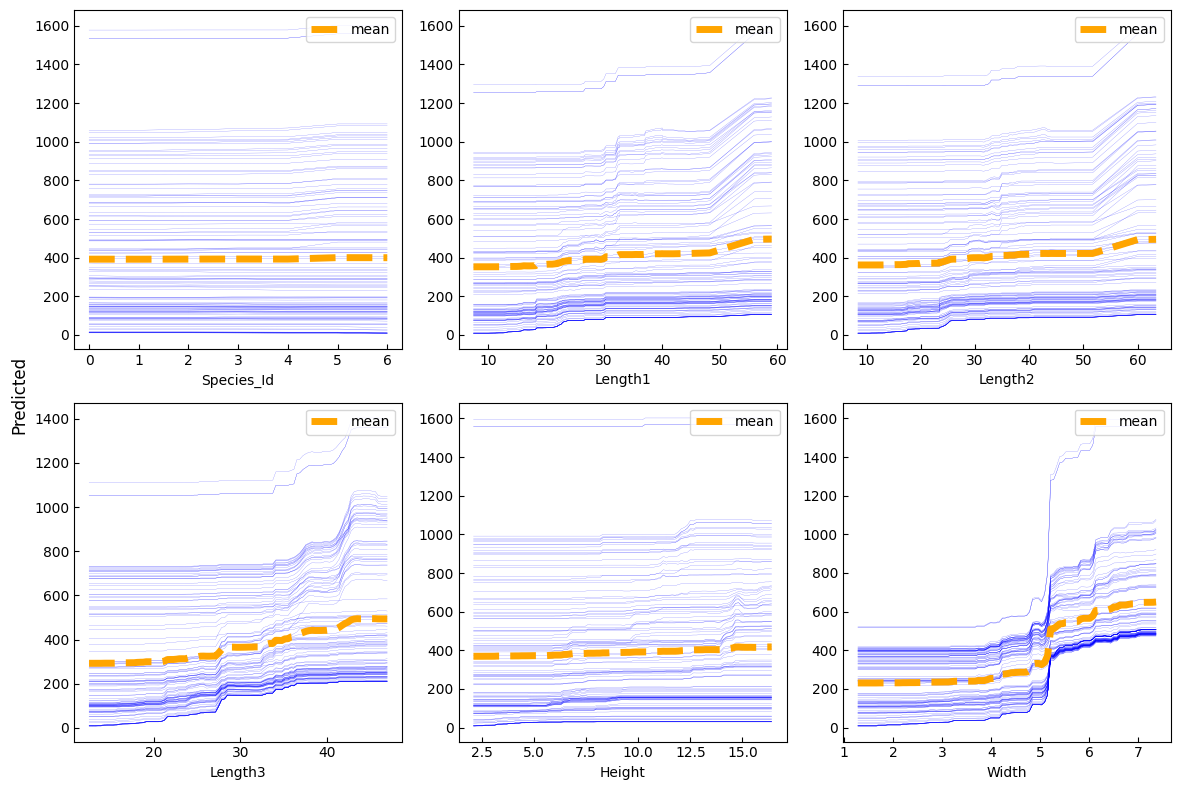

In [74]:
col_ind = 0
row_ind = 0
num_column = 3
num_row = int(len(X_train.columns) / num_column)

fig, ax = plt.subplots(num_row, num_column, figsize=(12, 8))
for column in X_train.columns:
    pd_and_ice = partial_dependence(forest, features=[column], percentiles=(0.05, 1-0.05), X=X_train, kind='individual')
    feature_grid = pd_and_ice['values'][0]
    pd_mean = pd_and_ice['individual'][0,:,:].mean(axis=0)
    pd_ind = np.squeeze(np.squeeze(pd_and_ice['individual']))

    for i in range(len(pd_ind)):
        ax[row_ind][col_ind].plot(feature_grid, pd_ind[i], color='blue', linewidth=0.1)
    ax[row_ind][col_ind].plot(feature_grid, pd_mean, label='mean', color='orange', linestyle = 'dashed', linewidth=5)
    ax[row_ind][col_ind].set_xlabel(column)
    ax[row_ind][col_ind].legend(loc='upper right') 
    
    col_ind += 1
    if col_ind == num_column:
        col_ind = 0
        row_ind += 1

fig.supylabel('Predicted')      
fig.tight_layout()
fig.show()

#### SHapley Additive exPlanations (SHAP)

In [81]:
explainer = shap.Explainer(forest, X_test)
shap_values = explainer(X_test,check_additivity=False)

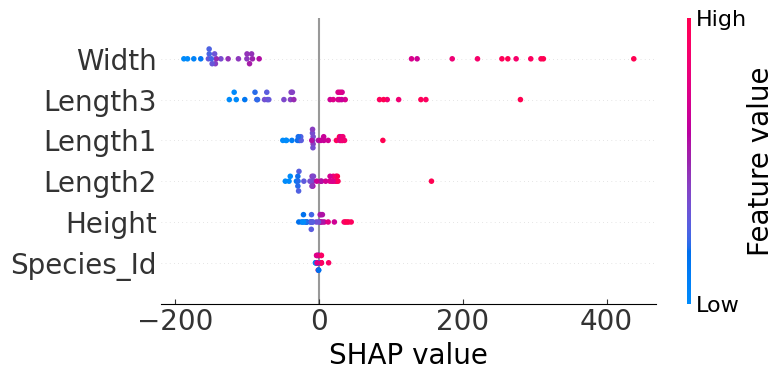

In [84]:
fig, ax = plt.gcf(), plt.gca()
shap.plots.beeswarm(shap_values, max_display=10, show=False)
ax.tick_params(labelsize=20)
ax.set_xlabel('SHAP value', fontsize=20)
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=16)
cb_ax.set_ylabel('Feature value', fontsize=20)
fig.tight_layout()
fig.show()

## Summary
The code predicted the weight of the fish in a random forest. It also visualized the variables' importance to clarify the model's behavior.  
I predicted that the type of fish would be the most important variable, but the results showed that the width of the fish was more important.  
If you find this code helpful, I would appreciate a star.  
Thank you for taking the time to look at this to the end.  　